**Business understanding:** “Global Mart” is an online store super giant having worldwide operations. It takes orders and delivers across the globe and deals with all the major product categories - consumer, corporate & home office.

**Objective:** Presently, we oversee 15 distinct product sub-categories, and our goal is to predict the quantities for each of these subcategories over the upcoming three months.

**Understanding the Data:** Presently, the dataset comprises transactional data, with each row denoting a specific order conducted on the online store. Within each transaction, there exist 24 attributes. The "Market" attribute encompasses 7 distinct factor levels, denoting the geographical market sector to which the customer is affiliated. Additionally, the "Segment" attribute indicates the customer's membership in one of the 3 segments. For a comprehensive list of attributes, please refer to the dataset's complete data dictionary, accessible through the provided link.

**Modeling Approach:** Within the realm of forecasting, there exist diverse time series models at our disposal. Initially, we will delve into comprehending the inherent trends and seasonal patterns within the data. Subsequently, through meticulous feature engineering, we will pinpoint the most effective attributes to model the series. This process will culminate in predicting the series values using the selected model, while simultaneously generating a new series derived from the disparity between the original and predicted series. The residual series resultant from this procedure should ideally approximate random noise. To execute this, we will leverage a widely recognized library known as "Prophet," developed by Facebook. Notably, "Prophet" has demonstrated its efficacy specifically in the domain of Demand Forecasting, which aligns seamlessly with our present use case.

**Model Assessment:** Following the development of a model that meets our criteria, the subsequent phase involves predicting the product quantities for the upcoming three months using this established model. To gauge the precision of these forecasts, an initial course of action entails segregating the final three months' values from the dataset. This segregation occurs post the aggregation of transaction-level data into monthly data points. Subsequently, we evaluate the three-month forecast accuracy by comparing it against the out-of-sample data points. For this assessment, the Mean Absolute Percentage Error (MAPE) stands as the chosen parameter for quantifying the forecast performance.

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import prophet
import itertools
from prophet import Prophet
import numpy as np
from IPython.display import display, HTML
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import logging
logger = logging.getLogger('fbprophet')
logger.setLevel(logging.WARNING)
import logging
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('/content/sample_data/Global Superstore.csv', encoding='Windows-1252')


In [ ]:
print("Dimensions:", df.shape)

Dimensions: (51290, 24)


In [ ]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
sorted_df = df.groupby('Sub-Category', group_keys=False).apply(lambda group: group.sort_values('Order Date'))
sorted_df.groupby('Sub-Category').size()
# accessories_data = sorted_df[sorted_df['Sub-Category'] == 'Tables'][['Order Date', 'Sub-Category']]
# pd.set_option('display.max_rows', len(accessories_data))
# sorted_df.groupby('Sub-Category').size()
#print(accessories_data)
# plt.figure(figsize=(10, 6))
# plt.hist(accessories_data['Order Date'], bins=10, edgecolor='black', alpha=0.7)
# plt.xlabel('Order Date')
# plt.ylabel('Frequency')
# plt.title('Distribution of Order Dates for Accessories')
# plt.xticks(rotation=45)
# plt.tight_layout()

# plt.show()


Sub-Category
Accessories    3075
Appliances     1755
Art            4883
Binders        6152
Bookcases      2411
Chairs         3434
Copiers        2223
Envelopes      2435
Fasteners      2420
Furnishings    3170
Labels         2606
Machines       1486
Paper          3538
Phones         3357
Storage        5059
Supplies       2425
Tables          861
dtype: int64

In [ ]:
sorted_df = sorted_df.drop(sorted_df[sorted_df['Sub-Category'] == 'Tables'].index)
sorted_df = sorted_df.drop(sorted_df[sorted_df['Sub-Category'] == 'Machines'].index)

In [ ]:
sorted_df = sorted_df.drop(columns=['Row ID','Order ID','Ship Date','Postal Code','Customer ID','Customer Name','City','State','Product ID','Product Name','Profit','Order Priority'])

In [ ]:
sorted_df.head(4)

Order Date       Ship Mode    Segment   Country Market   Region  \
28495 2011-01-02  Standard Class  Corporate    Panama  LATAM  Central   
1747  2011-01-03  Standard Class   Consumer   Ukraine   EMEA     EMEA   
18528 2011-01-03  Standard Class  Corporate   Germany     EU  Central   
28911 2011-01-04  Standard Class   Consumer  Colombia  LATAM    South   

         Category Sub-Category     Sales  Quantity  Discount  Shipping Cost  
28495  Technology  Accessories    81.984         2       0.4           6.21  
1747   Technology  Accessories  1470.780         6       0.0         146.55  
18528  Technology  Accessories   151.362         2       0.1          14.22  
28911  Technology  Accessories    47.560         1       0.0           6.00

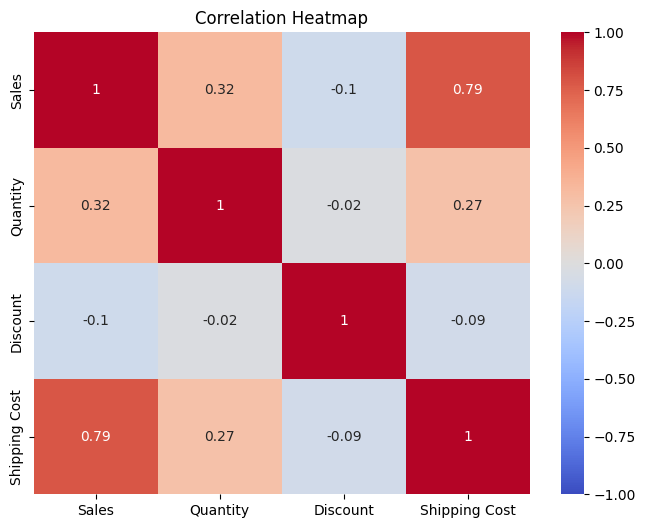

In [ ]:
correlation_matrix = sorted_df.corr()

# Create a correlation heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
df_final = df.groupby(['Sub-Category', 'Order Date'])['Quantity'].sum().reset_index()

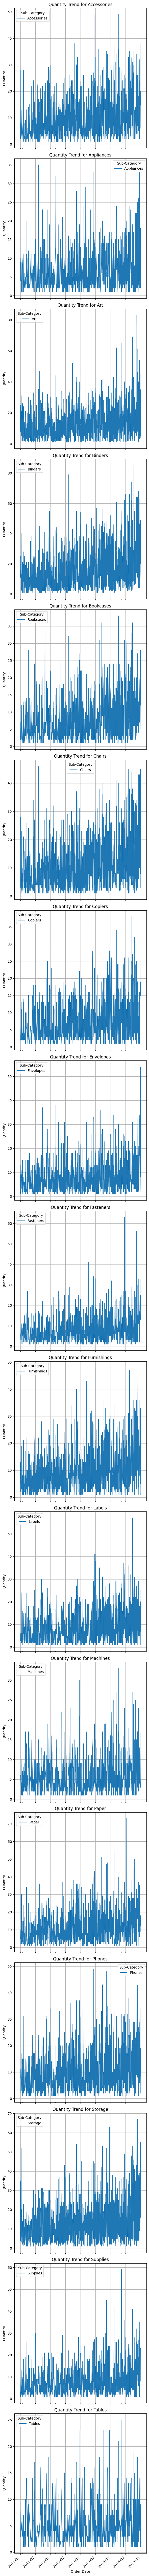

In [ ]:
# Get unique sub-categories
sub_categories = df_final['Sub-Category'].unique()

# Create subplots for each sub-category's quantity trend
fig, axs = plt.subplots(len(sub_categories), 1, figsize=(6, 6 * len(sub_categories)), sharex=True)

for idx, sub_category in enumerate(sub_categories):
    sub_df = df_final[df_final['Sub-Category'] == sub_category]
    pivot_table = sub_df.pivot(index='Order Date', columns='Sub-Category', values='Quantity')

    pivot_table.plot(kind='line', ax=axs[idx])
    axs[idx].set_title(f'Quantity Trend for {sub_category}')
    axs[idx].set_xlabel('Order Date')
    axs[idx].set_ylabel('Quantity')
    axs[idx].legend(title='Sub-Category')
    axs[idx].tick_params(axis='x', rotation=45)
    axs[idx].grid()


plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

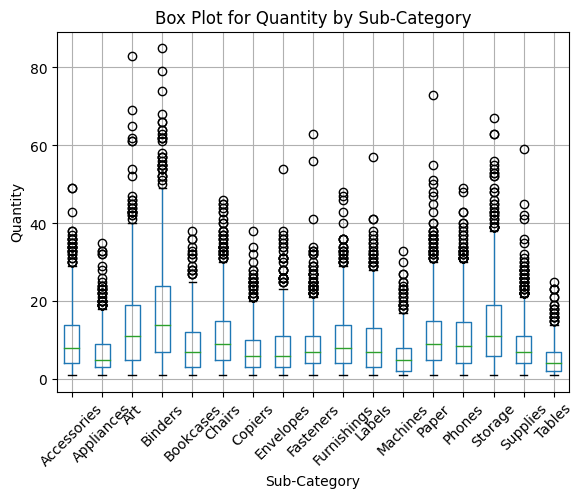

In [ ]:
plt.figure(figsize=(8, 6))
df_final.boxplot(column='Quantity', by='Sub-Category')
plt.title('Box Plot for Quantity by Sub-Category')
plt.suptitle('')  # Remove default title
plt.xlabel('Sub-Category')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.show()

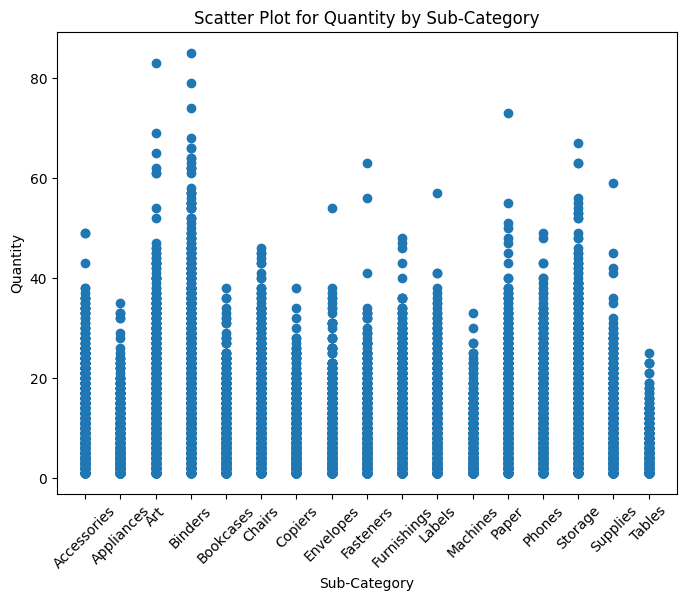

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(df_final['Sub-Category'], df_final['Quantity'])
plt.title('Scatter Plot for Quantity by Sub-Category')
plt.xlabel('Sub-Category')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df_final.head()

Sub-Category Order Date  Quantity
0  Accessories 2011-01-02         2
1  Accessories 2011-01-03         8
2  Accessories 2011-01-04         6
3  Accessories 2011-01-06        28
4  Accessories 2011-01-08        11

In [ ]:
df_final.groupby('Sub-Category').size()

Sub-Category
Accessories    1076
Appliances      887
Art            1226
Binders        1259
Bookcases      1000
Chairs         1108
Copiers         993
Envelopes      1021
Fasteners      1013
Furnishings    1126
Labels         1030
Machines        806
Paper          1125
Phones         1134
Storage        1235
Supplies       1013
Tables          578
dtype: int64

In [ ]:
grouped = df_final.groupby('Sub-Category').agg({'Order Date': ['min', 'max']})
grouped.columns = ['StartDate', 'EndDate']

# Calculate the number of missing dates between start and end dates
missing_dates = []
for sub_category, row in grouped.iterrows():
    date_range = pd.date_range(start=row['StartDate'], end=row['EndDate'])
    actual_dates = df_final[df_final['Sub-Category'] == sub_category]['Order Date']
    missing = len(date_range) - actual_dates.isin(date_range).sum()
    total_dates = len(date_range)
    missing_dates.append((sub_category, row['StartDate'], row['EndDate'], missing, total_dates))

missing_df = pd.DataFrame(missing_dates, columns=['Sub-Category', 'StartDate', 'EndDate', 'MissingDates', 'TotalDates'])

sorted_missing_df = missing_df.sort_values(by='MissingDates', ascending=False)

print(sorted_missing_df)



   Sub-Category  StartDate    EndDate  MissingDates  TotalDates
16       Tables 2011-01-03 2014-12-31           881        1459
11     Machines 2011-01-03 2014-12-31           653        1459
1    Appliances 2011-01-02 2014-12-31           573        1460
6       Copiers 2011-01-02 2014-12-31           467        1460
4     Bookcases 2011-01-02 2014-12-31           460        1460
15     Supplies 2011-01-01 2014-12-31           448        1461
8     Fasteners 2011-01-03 2014-12-31           446        1459
7     Envelopes 2011-01-02 2014-12-31           439        1460
10       Labels 2011-01-02 2014-12-31           430        1460
0   Accessories 2011-01-02 2014-12-31           384        1460
5        Chairs 2011-01-03 2014-12-31           351        1459
12        Paper 2011-01-01 2014-12-31           336        1461
9   Furnishings 2011-01-01 2014-12-31           335        1461
13       Phones 2011-01-03 2014-12-31           325        1459
2           Art 2011-01-02 2014-12-31   

In [ ]:
logger = logging.getLogger('prophet')
logger.setLevel(logging.WARNING)
logger.setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generating all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params

results = {}

for sub_category, sub_df in df_final.groupby('Sub-Category'):
    if(sub_category=='Art'):
      sub_df = sub_df.rename(columns={'Order Date': 'ds', 'Quantity': 'y'})

      rmse_per_param = {}

      for params in all_params:
          model = Prophet(**params).fit(sub_df)

          df_cv = cross_validation(model, initial='30 days', period='30 days', horizon='90 days')
          df_metrics = performance_metrics(df_cv)

          rmses.append(df_metrics['rmse'].values[0])

      results[sub_category] = rmse_per_param

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)
# for sub_category, rmse_per_param in results.items():
#     print(f"RMSEs for {sub_category}:")
#     for param_set, rmse in rmse_per_param.items():
#         print(f"{param_set}: {rmse}")

  0%|          | 0/45 [00:00<?, ?it/s]

20:08:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
20:08:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
20:08:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
20:08:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
20:08:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
20:08:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Cha

  0%|          | 0/45 [00:00<?, ?it/s]

20:08:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
20:08:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
20:08:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
20:08:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
20:08:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
20:08:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Cha

  0%|          | 0/45 [00:00<?, ?it/s]

20:09:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
20:09:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
20:09:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
20:09:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
20:09:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
20:09:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Cha

  0%|          | 0/45 [00:00<?, ?it/s]

20:10:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
20:10:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
20:10:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
20:10:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
20:10:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
20:10:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Cha

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

    changepoint_prior_scale  seasonality_prior_scale       rmse
0                     0.001                     0.01   9.689862
1                     0.001                     0.10   9.812122
2                     0.001                     1.00  12.460493
3                     0.001                    10.00  22.116439
4                     0.010                     0.01   9.586336
5                     0.010                     0.10   9.672015
6                     0.010                     1.00   9.951148
7                     0.010                    10.00  14.169949
8                     0.100                     0.01   9.598625
9                     0.100                     0.10   9.634640
10                    0.100                     1.00  10.003944
11                    0.100                    10.00  14.144244
12                    0.500                     0.01   9.685462
13                    0.500                     0.10   9.856488
14                    0.500             

In [ ]:
logger = logging.getLogger('prophet')
logger.setLevel(logging.WARNING)
logger.setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

models = {}
for sub_category, sub_df in df_final.groupby('Sub-Category'):
    model = Prophet(changepoint_prior_scale=0.01, seasonality_prior_scale=0.01)
    sub_df = sub_df.rename(columns={'Order Date': 'ds', 'Quantity': 'y'})
    model.fit(sub_df)

    future = model.make_future_dataframe(periods=90)  # Next 3 months
    forecast = model.predict(future)
    forecast['yhat'] = np.round(forecast['yhat'])
    models[sub_category] = (model, forecast)

    forecast.to_excel(f"{sub_category}_forecast.xlsx", index=False)

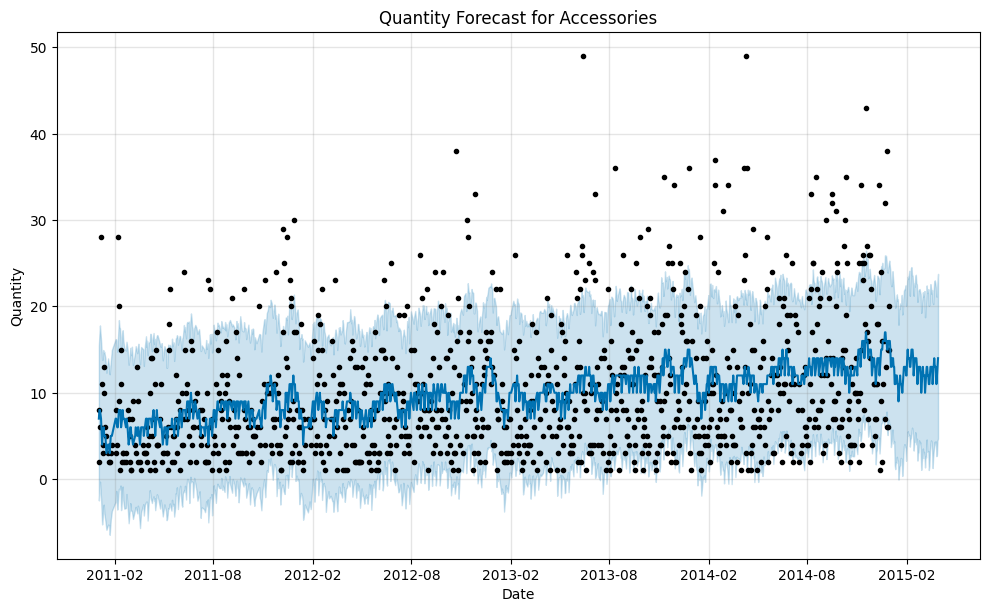

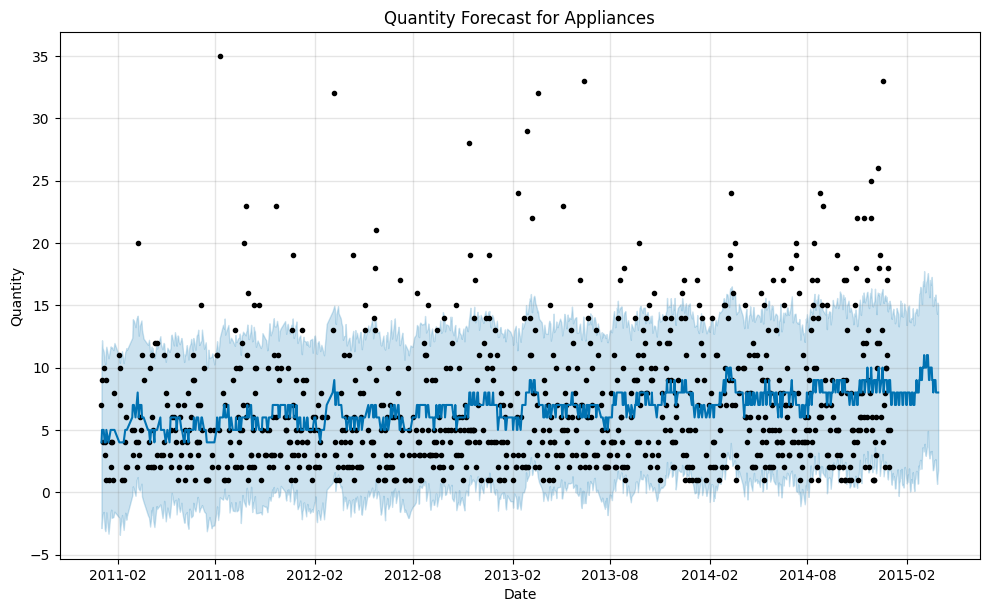

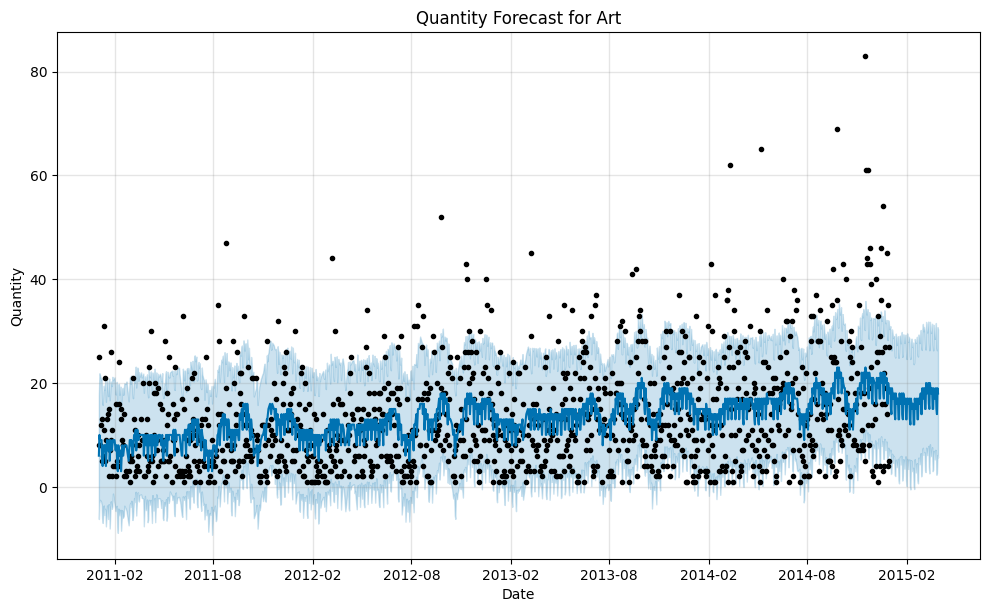

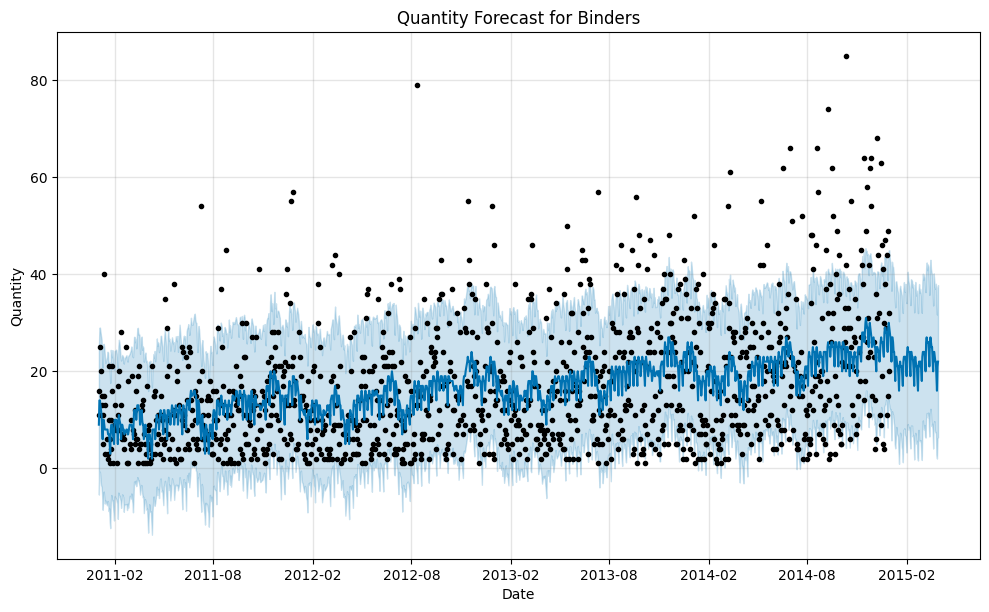

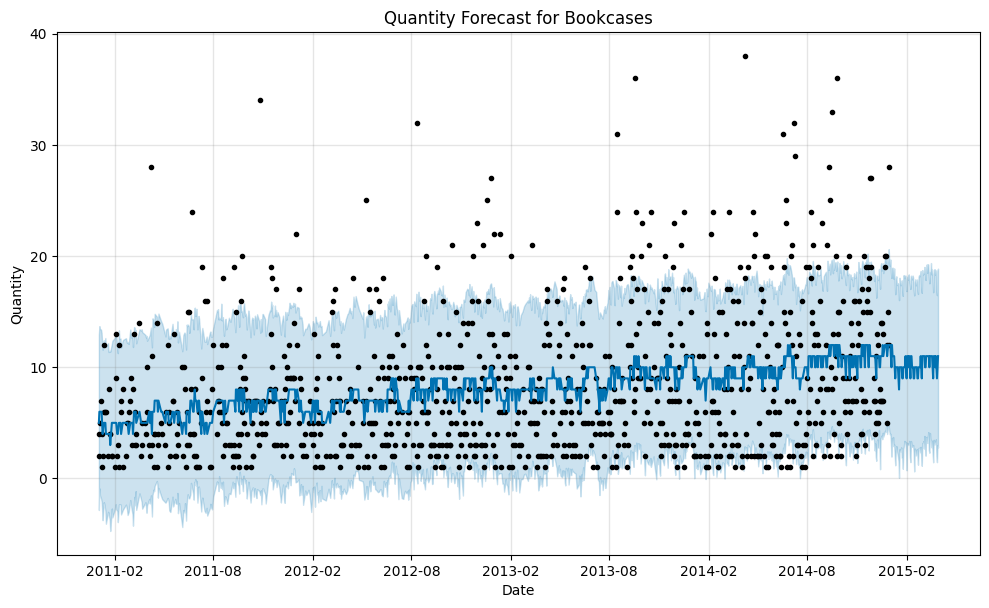

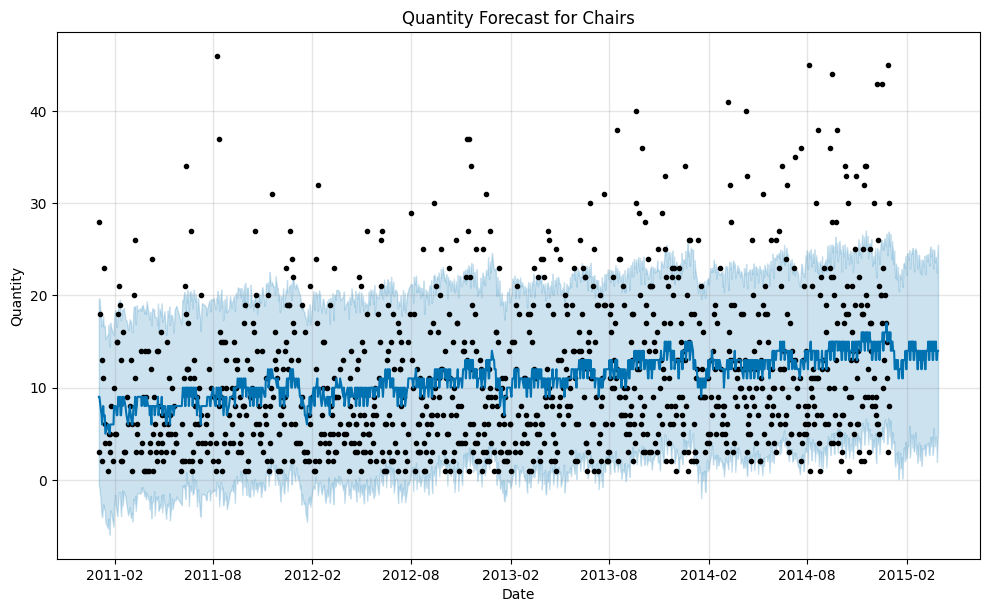

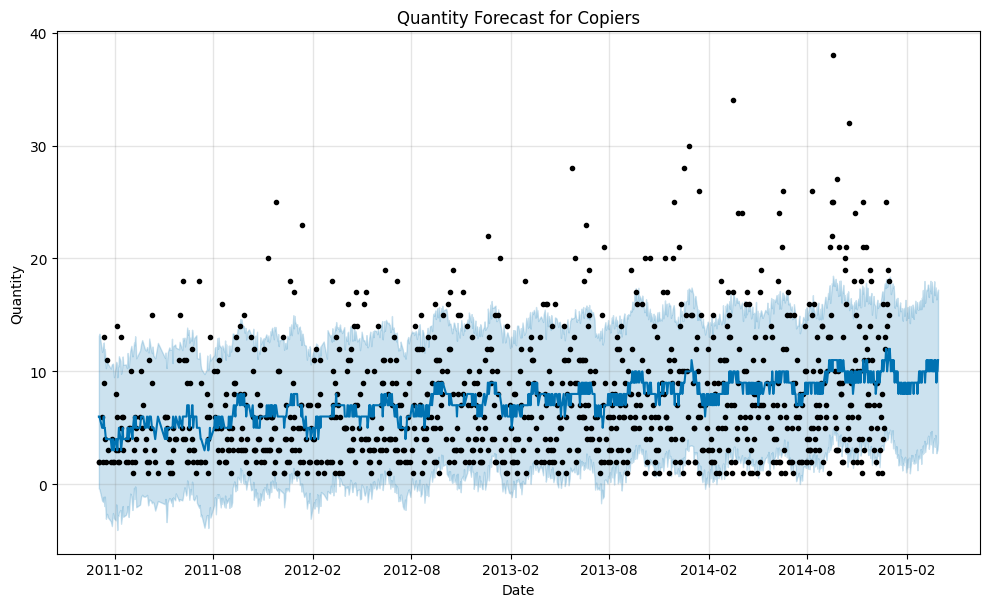

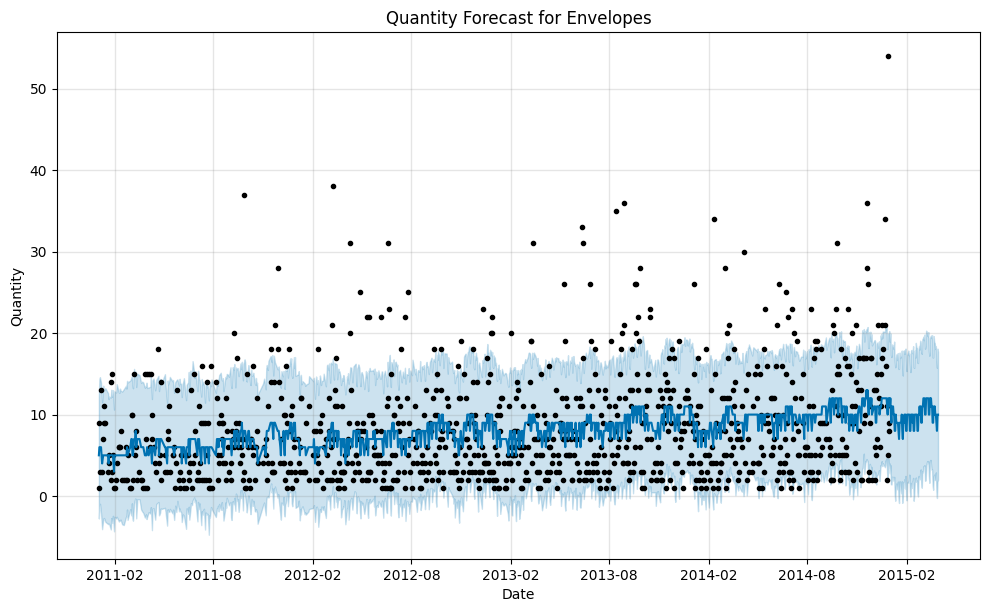

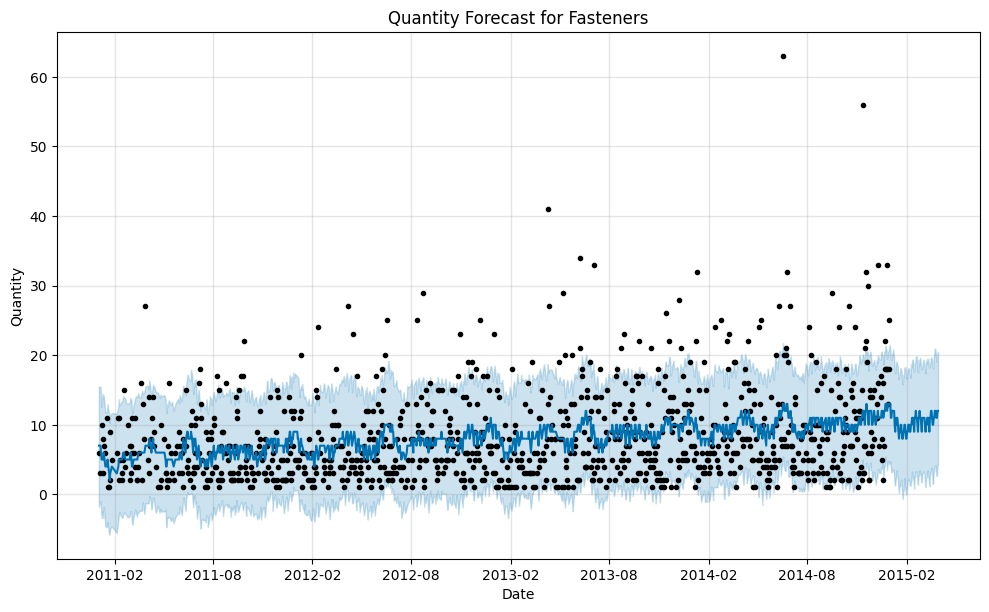

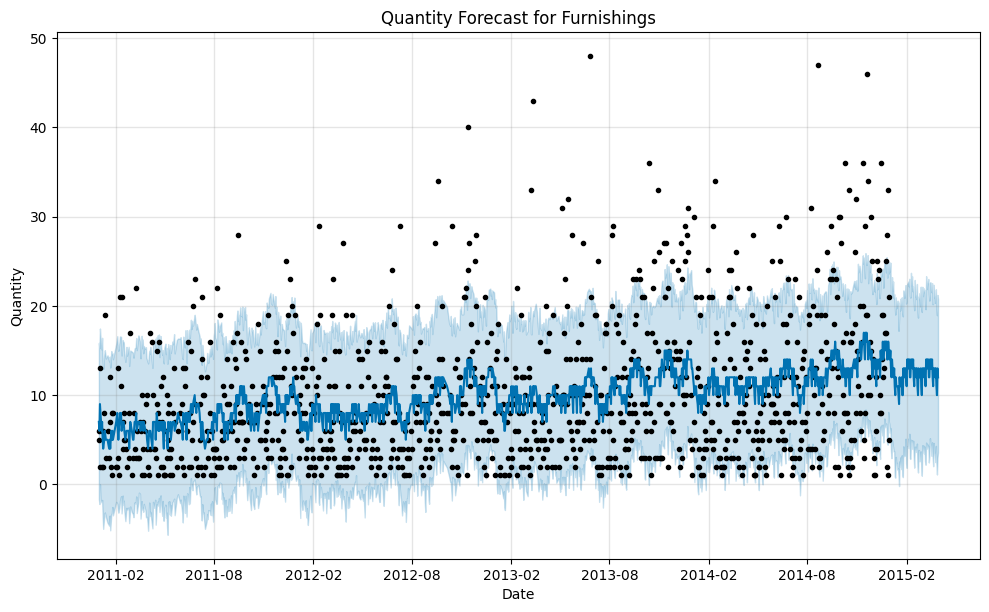

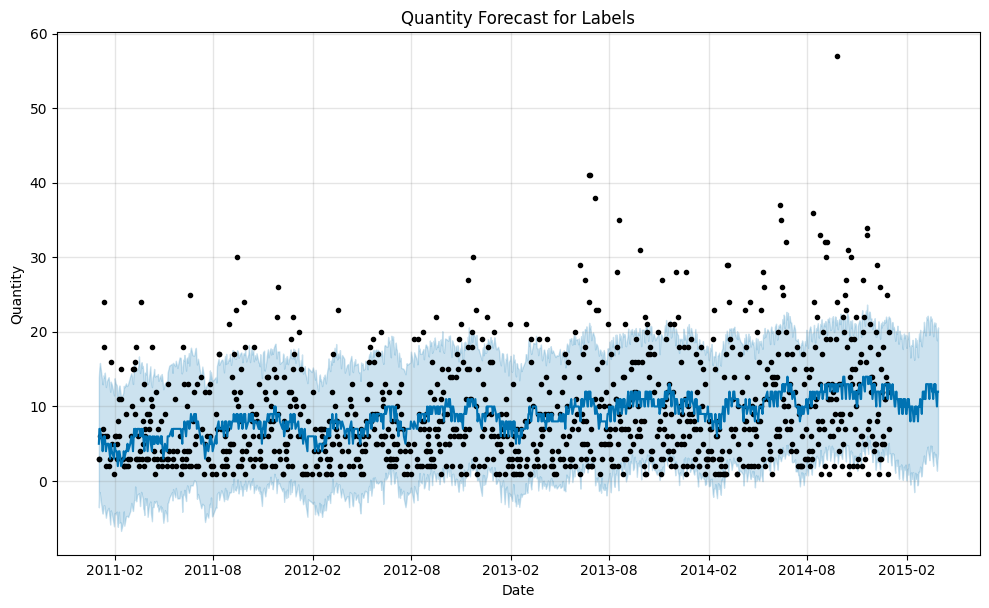

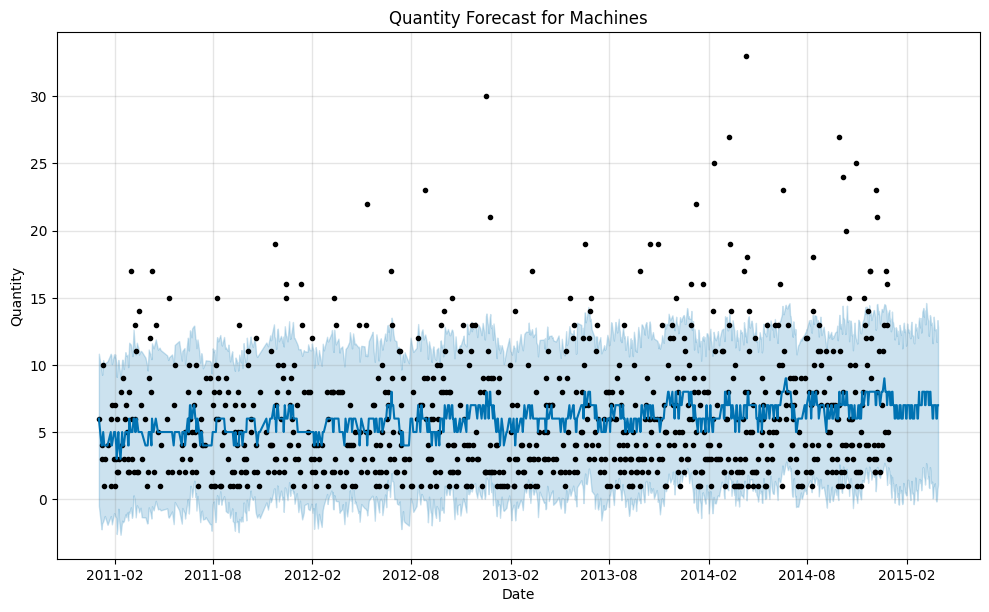

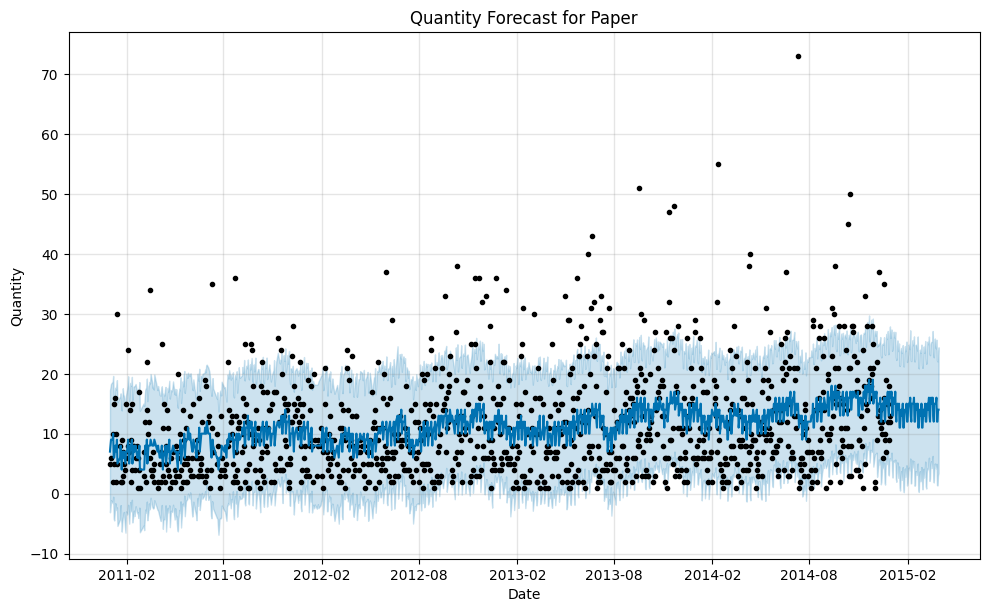

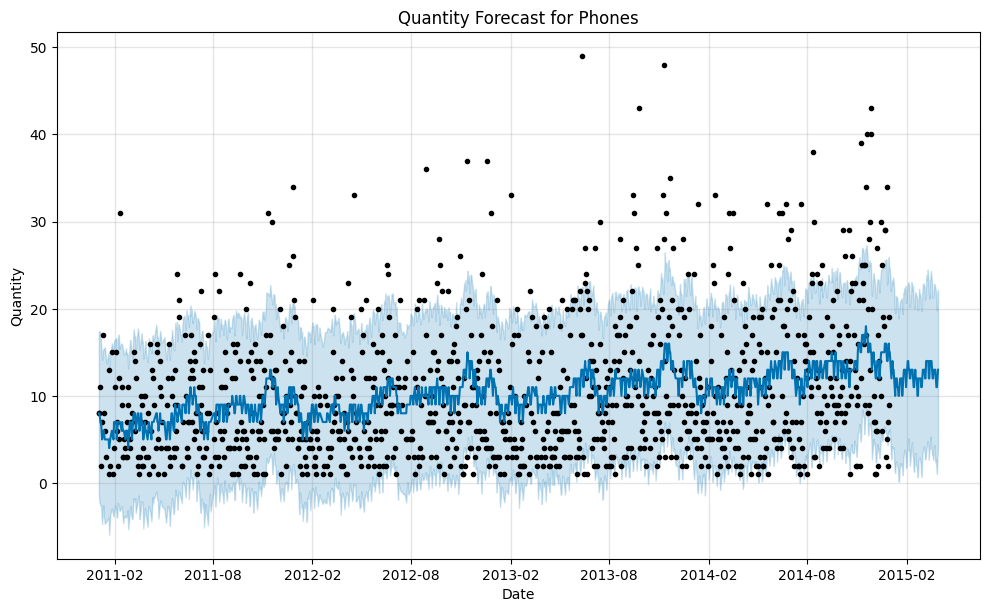

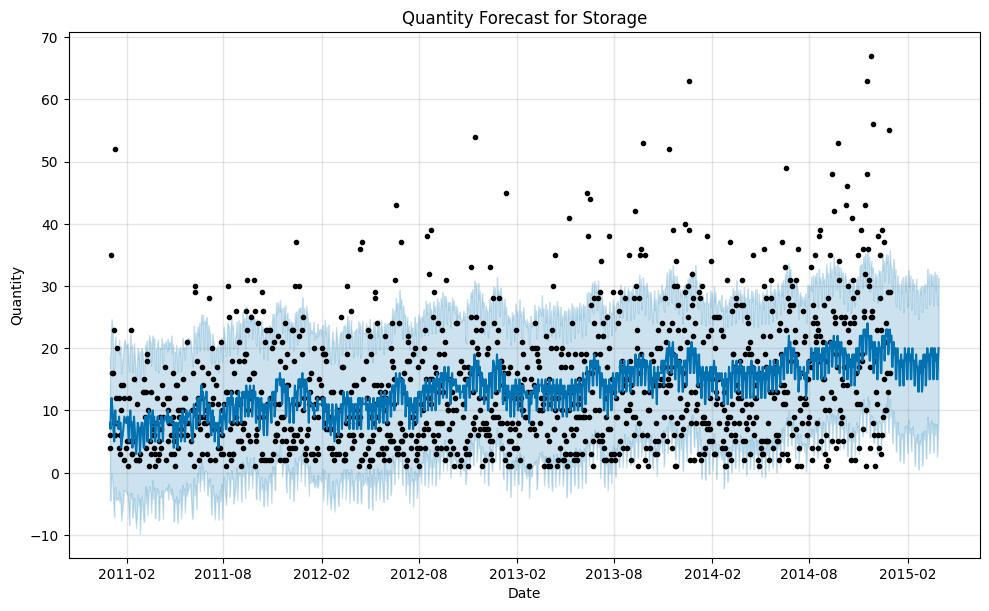

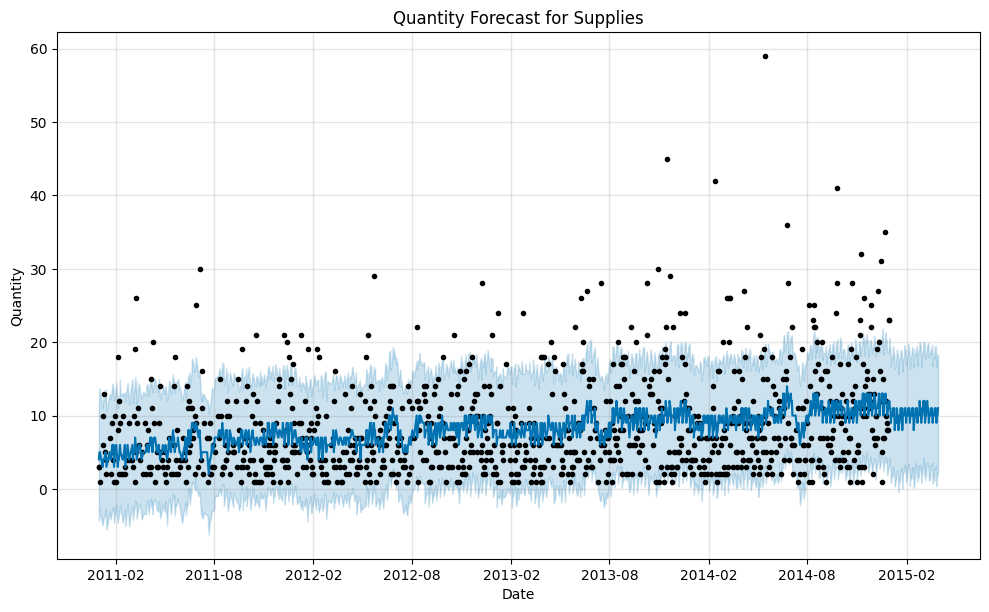

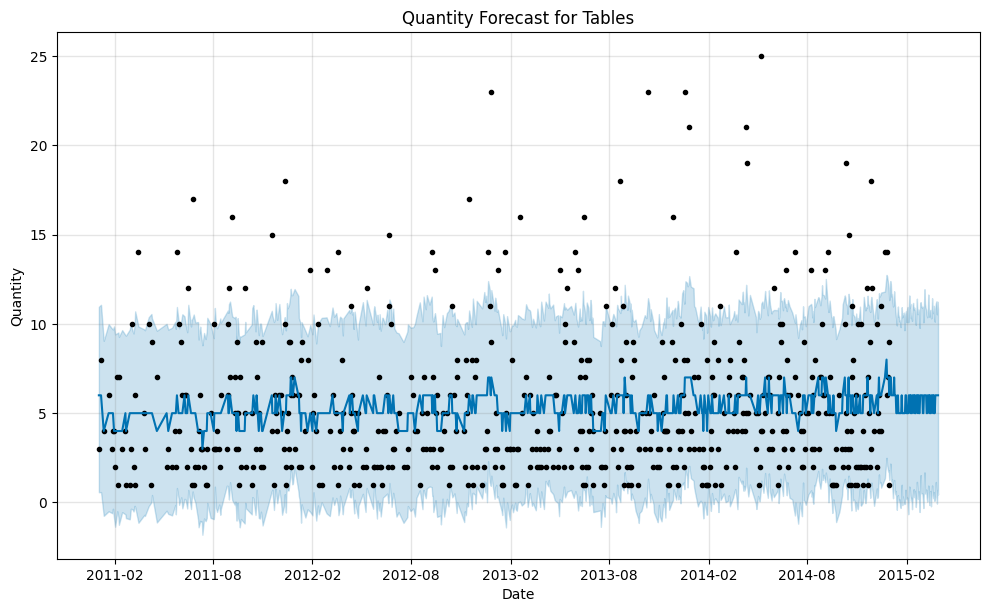

In [ ]:
for sub_category, (model, forecast) in models.items():
    fig = model.plot(forecast)
    plt.title(f'Quantity Forecast for {sub_category}')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.show()

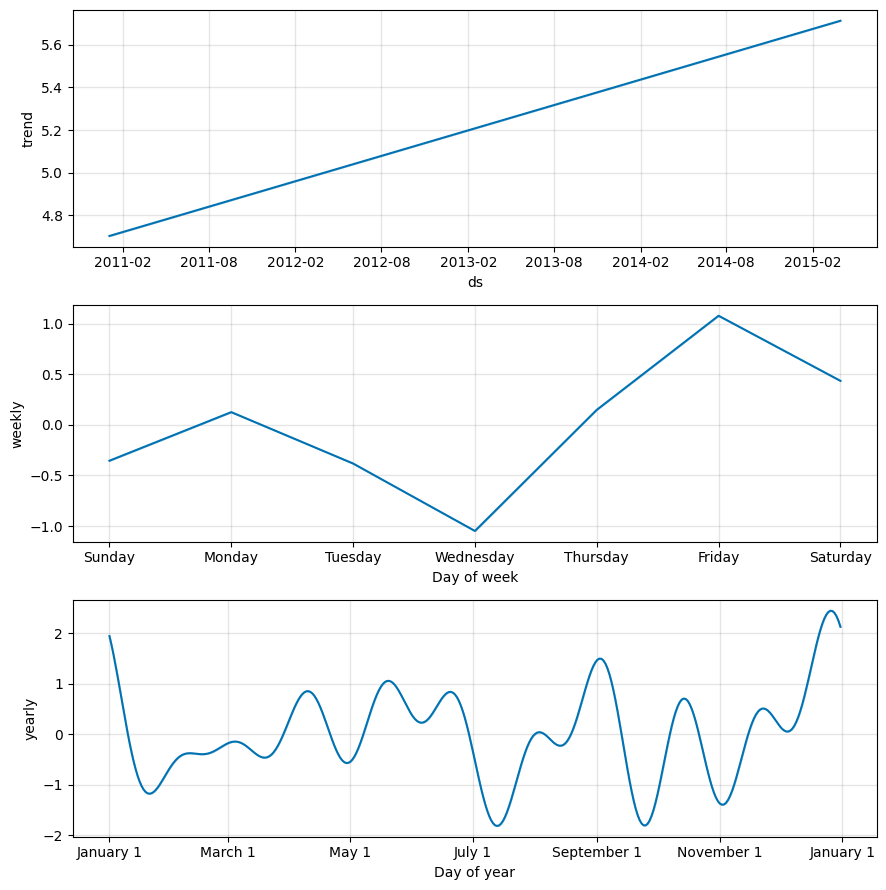

In [ ]:
fig2 = model.plot_components(forecast)

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

In [ ]:
plot_components_plotly(model, forecast)

In [ ]:
# sub_category_df = df_final[df_final['Sub-Category'] == 'Tables']

# # Set the max rows to display for the DataFrame
# pd.set_option('display.max_rows', None)

# # Display the subset DataFrame with vertical scrollbar
# display(HTML(sub_category_df.to_html(index=False)))

# # Reset the max rows to its default value
# pd.reset_option('display.max_rows')

In [ ]:
# grouped = df_final.groupby('Sub-Category').agg({'Order Date': ['min', 'max']})
# grouped.columns = ['StartDate', 'EndDate']

# # Create a DataFrame to store missing dates and weekdays
# missing_dates_df = pd.DataFrame(columns=['Sub-Category', 'MissingDate', 'Weekday'])

# # Iterate through sub-categories
# for sub_category, row in grouped.iterrows():
#     date_range = pd.date_range(start=row['StartDate'], end=row['EndDate'])
#     actual_dates = df_final[df_final['Sub-Category'] == sub_category]['Order Date']
#     missing_dates = date_range.difference(actual_dates)
#     weekdays = missing_dates.day_name()  # Get weekdays for missing dates

#     # Append missing dates and weekdays to the DataFrame
#     for date, weekday in zip(missing_dates, weekdays):
#         missing_dates_df = missing_dates_df.append({'Sub-Category': sub_category, 'MissingDate': date, 'Weekday': weekday}, ignore_index=True)

# # pd.set_option('display.max_rows', None)

# # # Display the DataFrame with vertical scrollbar
# # display(HTML(missing_dates_df.to_html(index=False)))

# # # Reset the max rows to its default value
# # pd.reset_option('display.max_rows')
# missing_dates_df['Weekday'].nunique()

7